# Introduction to scikit-learn \#2 #

We are going to build on top of the last lecture and learn about **Model Selection** and **Preprocessing**.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

## Cross Validation ##

After training your model you usually want to know how well it is performing. You should **NEVER** test your model on the same data that you used to train it. A model that memorizes the data will perform very well on the training set but probably very poorly on unseen data. This is called *overfitting*, when the model starts fitting the noise of the data instead of the true signal.  

Remember that the goal of Machine Learning is generalizing for unseen examples and, as such, we should always test on data that was not used for training. Scikit-learn allows us to do just that with the ```train_test_split``` function, splitting our data into *train* and *test* sets.

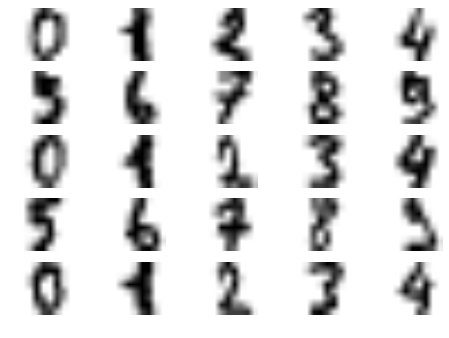

Accuracy on the training set = 1.0
Accuracy on the test set = 0.472222222222


In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from visualization_helper import plot_digits

digits = load_digits()
X, y = digits.data, digits.target

plot_digits()

X_train , X_test , y_train , y_test = train_test_split (X, y, train_size=0.7, random_state=0)

clf = SVC()
clf.fit(X_train, y_train)

print 'Accuracy on the training set =', clf.score(X_train, y_train)
print 'Accuracy on the test set =', clf.score(X_test, y_test)

An *SVM* with the default parameters is able to correctly classify all training examples, but only classifies $47\%$ of the test set correctly. It is clearly *overfitting*.

Now we need to tune the hyper-parameters of the model. The way we do it is by training a model with some hyper-parameters on a training set and validate it on another set. We should not validate it on the test set, otherwise we risk *overfitting* to the test set and we can no longer trust our results.

We need a third set, called the *validation set*. The problem is that with all these divisions we might end up with few trainig data. The solution is to use *cross-validation*:

![Cross Validation](cross-validation.jpg)

We divide the data into k-folds and perform k-fits, where each fold takes turns as the validation set. The green area corresponds to the whole *training set* and, at each iteration, we use the red area as the *training set* and the green area as the *validation set*.

In [3]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score (clf , X_train, y_train, cv=5)
print 'Scores: {0}'.format(scores)
print 'Accuracy = {0:.2f} +/- {1:.2f}'.format(scores.mean(), scores.std() * 2)

Scores: [ 0.50196078  0.43873518  0.47826087  0.43373494  0.46153846]
Accuracy = 0.46 +/- 0.05


We can then use the mean of the scores as a surrogate for the validation score and the double of the standard deviation as the $95\%$ confidence interval.

### Grid Search ###

Now we have everything we need to start the search for the best hyper-parameters: we divide our model into *train* and *test* set and evaluate our hyper-parameter's choice on the *validation* set using *cross validation*.

*Grid Search* helps us generate hyper parameters' candidates to try. We define values that we want to try and *Grid Search* tries all the possible combinations:

![Grid Search](grid-search.jpg)

In [4]:
from sklearn.grid_search import GridSearchCV

param_grid = [
    {'C': [1, 1e1], 'gamma': [1e-2, 1e-4]},
]

grid = GridSearchCV(clf, param_grid=param_grid, cv=3, scoring='precision_weighted')
grid.fit(X_train, y_train)
print grid.grid_scores_

[mean: 0.93087, std: 0.00119, params: {'C': 1, 'gamma': 0.01}, mean: 0.96430, std: 0.00397, params: {'C': 1, 'gamma': 0.0001}, mean: 0.93263, std: 0.00140, params: {'C': 10.0, 'gamma': 0.01}, mean: 0.98679, std: 0.00300, params: {'C': 10.0, 'gamma': 0.0001}]


We can see that ```GridSearchCV``` automatically combined and tested the hyper-parameters. Now let's try with more hyper-parameters and more cross validation folds:

In [5]:
param_grid = [
    {'C': [1, 1e1], 'gamma': [1e-2, 1e-4]},
    {'C': [1e1, 1e2, 1e3], 'kernel': ['linear', 'rbf'], 'gamma':[1e-2, 1e-4]},
]

grid = GridSearchCV(clf, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

print 'Grid Search best score =', grid.best_score_
print 'Grid Search best parameters =', grid.best_params_

Grid Search best score = 0.988066825776
Grid Search best parameters = {'kernel': 'rbf', 'C': 100.0, 'gamma': 0.0001}


Let's test it now on the test set:

In [6]:
print 'Accuracy (train) =', grid.score(X_train, y_train)
print 'Accuracy (test) =', grid.score(X_test, y_test)
print 'Same:', grid.best_estimator_.score(X_test, y_test)

Accuracy (train) = 1.0
Accuracy (test) = 0.983333333333
Same: 0.983333333333


We were able to improve the accurcy from $47\%$ to $98\%$ with a simple *Grid Search*. Not bad! We can check which mistakes the model made:

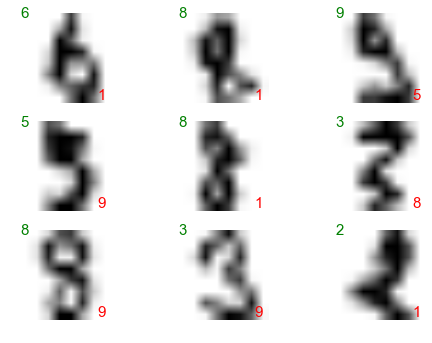

In [7]:
from visualization_helper import plot_wrong_predictions

plot_wrong_predictions(grid, X_test, y_test, width=3, height=3)

A human would probably not make most of these mistakes, although we can see why the model made some of them.

### Randomized Search ###

Some hyper-parameters do not influence the model's performance and, as *Grid Search* gives equal attention to every hyper-parameter, we are wasting time. *Random Search*[1] solves this issue. It searches the space randomly for a predetermined number of iterations. Since at each iteration we are testing a new value for all hyper-parameters, as long as there is at least one relevant hyper-parameter, all iterations matter. Also, the number of iterations is independent of the number of parameters to try, so it is easier to work on a budget of time.

![Random Search](random-search.jpg)

[1] Bergstra, J. and Bengio, Y., Random search for hyper-parameter optimization, The Journal of Machine Learning Research (2012)

In [8]:
from scipy.stats import randint, uniform
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import f1_score

param_distributions = {
    'C': randint(1, 11), 'kernel': ['linear', 'rbf'], 'gamma': uniform(loc=1e-4, scale=9e-4)
}

rsearch = RandomizedSearchCV(clf, param_distributions=param_distributions, cv=10, n_iter=15)
rsearch.fit(X_train, y_train)

print 'Random Search best score =', rsearch.best_score_
print 'Random Search best parameters =', rsearch.best_params_
print 'Accuracy (train) =', rsearch.score(X_train, y_train)
print 'Accuracy (test) =', rsearch.score(X_test, y_test)

Random Search best score = 0.992044550517
Random Search best parameters = {'kernel': 'rbf', 'C': 7, 'gamma': 0.0007750929988866515}
Accuracy (train) = 1.0
Accuracy (test) = 0.992592592593


The ```param_distributions``` parameter is a dictionary that maps a key to a distribution. These distributions must implement the ```rvs``` function, such as scipy's distributions.

The RandomizedSearchCV was able to get a slightly better result on the test set. While the difference is small in this case, on more difficult datasets the difference might be bigger.

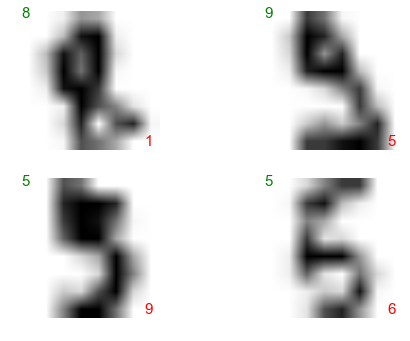

In [9]:
from visualization_helper import plot_wrong_predictions

plot_wrong_predictions(rsearch, X_test, y_test)

### Exercise ###

1\. Use GridSearch to find the optimal hyper-parameters for a LogisticRegression. Find the best *C* and *penalty* to use.

In [ ]:
from sklearn.linear_model import LogisticRegression

#########################################################
#                       YOUR CODE                       #
#########################################################

#########################################################
#########################################################

## Evaluation ##

It was easy to see where the model got wrong in this case, since it made very few mistakes. However, if we were to make the same exercise on the default classifier (the one with $47\%$ accuracy) we would need to look into a lot of images.

There is a "standard" way of evaluating the accuracy of a model and it is called the *Confusion Matrix*. Let's start with a simple example:

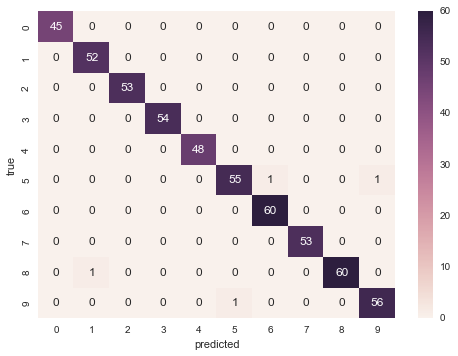

In [10]:
from sklearn.metrics import confusion_matrix
from visualization_helper import plot_confusion_matrix

y_pred = rsearch.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf)

As we have seen in the previous example we have one $8$ predicted as $1$, one $9$ predicted as $5$, one $5$ predicted as $6$ and another $5$ predicted as $9$. All the other examples were correctly classified (the ones at the diagonal).

Now let's look at the *Confusion Matrix* of the classifier with $47\%$ accuracy:

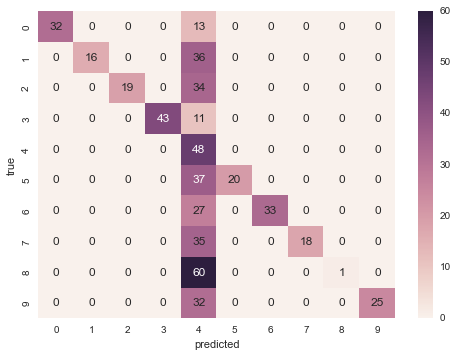

In [11]:
clf = SVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf)

We can see that the model is highly biased towards classifying $4$'s. 

We can also print a classification report, that gives us objective measures of how the model is performing.

In [12]:
from sklearn.metrics import classification_report

print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          0       1.00      0.71      0.83        45
          1       1.00      0.31      0.47        52
          2       1.00      0.36      0.53        53
          3       1.00      0.80      0.89        54
          4       0.14      1.00      0.25        48
          5       1.00      0.35      0.52        57
          6       1.00      0.55      0.71        60
          7       1.00      0.34      0.51        53
          8       1.00      0.02      0.03        61
          9       1.00      0.44      0.61        57

avg / total       0.92      0.47      0.53       540



Overall, the average precision is very high precision since, exept for the case of the number $4$, there are no False Positives. On the other hand, the recall is very low since there are a lot of False Negatives.

It is possible to get these metrics individually by using the functions available on the ```sklearn.metrics``` module:

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

y_pred = clf.predict(X_test)
print 'Accuracy = {0:.2f}'.format(accuracy_score(y_test, y_pred))
print 'Precision = {0:.2f}'.format(precision_score(y_test, y_pred, average='weighted'))
print 'Recall = {0:.2f}'.format(recall_score(y_test, y_pred, average='weighted'))
print 'f1 = {0:.2f}'.format(f1_score(y_test, y_pred, average='weighted'))

Accuracy = 0.47
Precision = 0.92
Recall = 0.47
f1 = 0.53


**Metrics interface:**
- Functions ending in ```_score``` return a value where higher is better;
- Functions ending in ```_loss``` or ```_error``` (i.e. ```log_loss``` and ```mean_squared_error```) return a value where lower is better;
- Create your own scorer with ```make_scorer```.

It is very easy to create your own scorer to be used with *GridSearchCV*: you just need to implement a function that receives the true and predicted labels as input and output a value.

In [14]:
from sklearn.metrics import make_scorer

def count_incorrect_function(y_true, y_pred):
    return sum(y_true != y_pred)

count_incorrect_loss = make_scorer(count_incorrect_function, greater_is_better=False)
print 'Number of incorrect predictions =', count_incorrect_loss(clf, X_test, y_test)

Number of incorrect predictions = -285


**Note:** The ```greater_is_better = False``` parameter negates the value of the function.

You can also pass arguments to the score function. This might be interesting to create a wrapper over existing metrics:

In [15]:
count_correct_score = make_scorer(accuracy_score, normalize=False)
corr_scorer = count_correct_score(clf, X_test, y_test)

accuracy = accuracy_score(y_test, clf.predict(X_test), normalize=False)

print 'Number of correct examples = {0} = {1}'.format(corr_scorer, accuracy)

Number of correct examples = 255 = 255


### Exercise: ### 

2\. Use a different score function with the *GridSearchCV* method. Check [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for some score functions (i.e. the ```average_precision_score```). You can reuse the same code from the previous exercise.

In [ ]:
#########################################################
#                       YOUR CODE                       #
#########################################################

#########################################################
#########################################################

## Preprocessing ##

Many Machine Learning algorithms make the assumption that the input features look like a standard normal distribution, with 0 mean and unit variance. Take the regularization term as an example, if one feature has a higher variance than the others, it will dominate the objective function and may make the model perform poorly.

Scikit-learn already has some functions to help you preprocess the input, following various strategies. Again, you should compute the statistics of the data on your training set, not on the whole set.

### Before normalization ###
Mean of features = [ 1.465  2.599]
Standard Deviation of features = [ 0.775  1.868]

### Train set ###
Mean of features = [ 0. -0.]
Standard Deviation of features = [ 1.  1.]

### Test set ###
Mean of features = [-0.235  0.112]
Standard Deviation of features = [ 0.868  1.028]


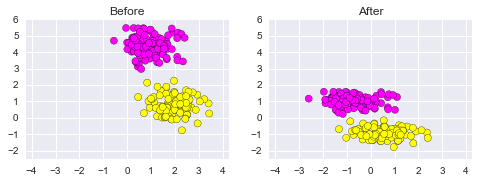

In [16]:
from visualization_helper import print_dataset_statistics, plot_normalized_dataset
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
X_train , X_test , y_train , y_test = train_test_split (X, y, train_size=0.7, random_state=0)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

print '### Before normalization ###'
print_dataset_statistics(X)
print '\n### Train set ###'
print_dataset_statistics(X_normalized)
print '\n### Test set ###'
print_dataset_statistics(X_test_normalized)

plot_normalized_dataset(X, X_normalized, X_test_normalized, y, y_train, y_test)

The mean and standard deviation of the transformed test set was not normalized, but that is ok. If we had more data, the training set would better capture the data distribution and they would be closer to the standard. Either way, the important is that the training data follows a standard normal distribution.

We can see that the data was translated closer to the origin and that it was scaled up in the x-axis and scaled down on the y-axis.

Some problems have categorical variables, for instance you may want to use a person's city in some classification problem i.e. ```['Porto', 'Lisbon', 'Faro']```. Scikit-learn does not work with strings, you need to convert them to a numerical representation.

One could be tempted to represent ```Porto``` as a $0$, ```Lisbon``` as a $1$ and ```Faro``` as a $2$ but this might not work well. The problem is that we can not say that ```Porto``` < ```Lisbon``` < ```Faro```, but the underlying algorithm would make that assumption. On the other hand, you could keep variables like ```short``` < ```medium``` < ```tall```.

A typical way of solving this problem is with the *One Hot Encoding* technique. With this techinque, you would repres ```Porto``` as $[1, 0, 0]$, ```Lisbon``` as $[0, 1, 0]$ and ```Faro``` as $[0, 0, 1]$. 

In [17]:
from visualization_helper import convert_to_numerical
from sklearn.preprocessing import OneHotEncoder

m = [['Porto', 'tall', 0.5], ['Lisbon', 'short', 0.25], ['Faro', 'medium', 0.75]]
m = convert_to_numerical(m)

enc = OneHotEncoder(categorical_features=[0, 1])
enc.fit(m)

print '### Before One Hot Encoding ###'
print m
print '\n### After One Hot Encoding ###'
print enc.transform(m).toarray()

### Before One Hot Encoding ###
[[0, 2, 0.5], [1, 0, 0.25], [3, 1, 0.75]]

### After One Hot Encoding ###
[[ 1.    0.    0.    0.    0.    1.    0.5 ]
 [ 0.    1.    0.    1.    0.    0.    0.25]
 [ 0.    0.    1.    0.    1.    0.    0.75]]


Sometimes your data might not be linearly separable and it turns out that preprocessing can help.

Imagine this kind of dataset:

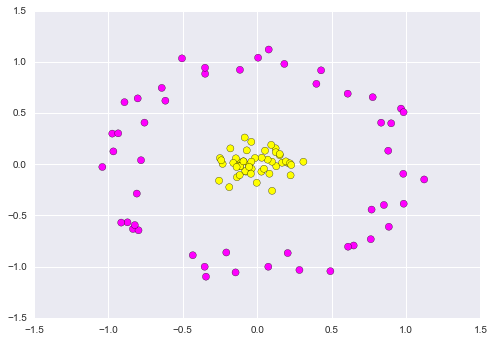

In [18]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

Clearly it is not possible to directly apply a linear classifier on this data. We can apply a **kernel** (remember the paramater of the *SVC*) to transform this data in such a way that it becomes linearly separable. 

Notice how the yellow points are closer to the origin. If we add a third dimension to our data equal to the distance to the origin, all the pink points would be above the yellow ones.

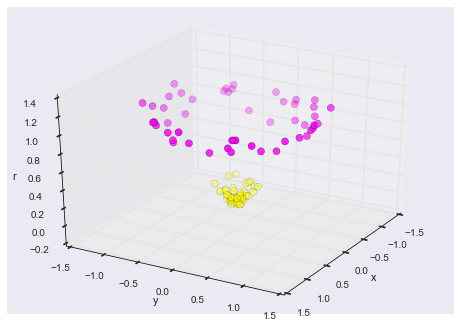

In [19]:
from sklearn.preprocessing import FunctionTransformer
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X_t[:, 0], X_t[:, 1], X_t[:, 2], c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

def square_kernel(x):
    return np.hstack((x, np.sqrt(x[:, 0:1]**2 + x[:, 1:]**2)))

transformer = FunctionTransformer(square_kernel)
X_t = transformer.transform(X)
interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

To do that, we created our own transformer using the *FunctionTransformer* class. This allows us to create our own transformers.

Nonetheless, this is a very simple kernel and scikit-learn allows you to apply a Polynomial kernel using the *PolynomialFeatures* class. It creates all possible polynomial combinatios with the degree less than or equal to the specified.

*Example:*

degree = 3: $[a, b] => [a, b, a^2, ab, b^2, a^3, a^2b, ab^2, 4^3]$  
degree = 2: $[a, b, c] => [a, b, c, a^2, ab, ac, b^2, bc, c^2]$

In [20]:
from sklearn.preprocessing import PolynomialFeatures

m = [[1, 2], [3, 4], [5, 6]]

enc = PolynomialFeatures(degree=2, include_bias=True)
enc.fit(m)
enc.transform(m)

array([[  1.,   1.,   2.,   1.,   2.,   4.],
       [  1.,   3.,   4.,   9.,  12.,  16.],
       [  1.,   5.,   6.,  25.,  30.,  36.]])

By default ```include_bias=True```, and a $1$ will be added as the first element of each feature vector.

## Pipeline ##

Scikit-learn allows you to chain multiple estimators into one single construct. It is called the *Pipeline*. With the *Pipeline* you can perform preprocessing, feature selection and classification calling *fit* and *predict* once. Also, as *GridSearchCV* and *RandomizedSearchCV* accept pipelines as input, you can perform joint hyper-parameter search.

In this example we start by scaling the input features to be inside the $[0-1]$ range and feed the output to a *Restricted Boltzmann Machine* (RBM). This has to be done since RBMs only accept binary inputs or values between 0 and 1. Then, the output of the RBM is fed to a logistic regression classifier. This is actually a Neural Network with one hidden layer trained on a greedy fashion, but we will get back to that.

In [21]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

digits = load_digits()
X, y = digits.data, digits.target
X_train , X_test , y_train , y_test = train_test_split (X, y, train_size=0.7, random_state=0)

rbm = BernoulliRBM()
logistic = LogisticRegression()
scaler = MinMaxScaler()

pipeline = Pipeline([('scaler', scaler), ('rbm', rbm), ('logistic', logistic)])

param_distributions = {
    'rbm__n_components': randint(64, 100), 'rbm__learning_rate': uniform(loc=3e-3, scale=7e-2), 
    'rbm__n_iter': randint(15, 25), 'logistic__C': randint(1e3, 1.5e3)
}

search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, cv=3, n_iter=25)

search.fit(X_train, y_train)
print 'Random Search best score =', search.best_score_
print 'Random Search best parameters =', search.best_params_
print 'Accuracy (train) =', search.score(X_train, y_train)
print 'Accuracy (test) =', search.score(X_test, y_test)
print classification_report(y_test, search.predict(X_test))

Random Search best score = 0.941925218775
Random Search best parameters = {'logistic__C': 1438, 'rbm__n_iter': 23, 'rbm__learning_rate': 0.0036569170786617065, 'rbm__n_components': 71}
Accuracy (train) = 0.958631662689
Accuracy (test) = 0.935185185185
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        45
          1       0.90      0.87      0.88        52
          2       0.94      0.94      0.94        53
          3       0.98      0.89      0.93        54
          4       0.96      0.98      0.97        48
          5       0.95      0.95      0.95        57
          6       0.94      0.98      0.96        60
          7       0.88      0.98      0.93        53
          8       0.95      0.90      0.92        61
          9       0.88      0.89      0.89        57

avg / total       0.94      0.94      0.94       540



As we have seen it is possible to use the pipeline the same way we use a normal estimator.

RBMs are trained in a completelly unsupervised fashion and they were the start of Deep Learning back in 2006. No one uses them now, but they are important for historical reasons.

We can greedly train an RBM and then feed its output as the input to a second RBM. These networks are known as Deep Belief Networks. Therefore, it is possible to create (useless) deep neural networks on scikit-learn.

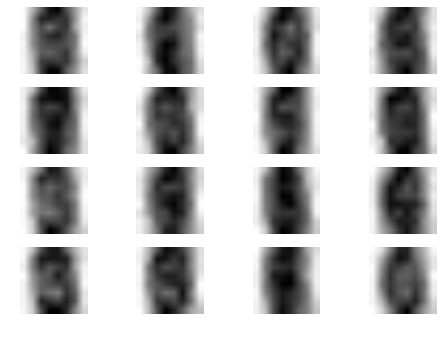

In [23]:
from visualization_helper import plot_rbm_weights
rbm = search.best_estimator_.named_steps['rbm']
plot_rbm_weights(rbm)

Each of these images correspond to the weights (the lines) that connect the input (red) to one of the hidden activations (blue). If we consider the figure below, this toy neural network would have 3 of the previously ploted figures.

![Neural Network](neural-network.jpg)

The RBM performs a dot product between the input image and the weights, which will give a large value when they are similar and a low value when they are very different. This value is then passed through a sigmoid function, which will squash the values between 0 and 1. The top blue unit will output a one when the image is similar to its weights and a 0 when it is very different.

The logistic regression then only needs to combine all this information (i.e. if it similar to $3$'s and $8$'s it is probably an $8$).

### Exercise: ### 

3\. Create a Deep Belief Network with 2/3 RBMs and a Logistic Regression model at the end. **Bonus:** plot the weights of the second RBM.

In [ ]:
#########################################################
#                       YOUR CODE                       #
#########################################################

#########################################################
#########################################################

## Feature Union ##

You might want to transform your data using different methods and then combine the output in order to feed it to a classifier. *FeatureUnion* allows you to do that, by combining multiple transformer objects into one. You can insert the *FeatureUnion* inside a *Pipeline* and use it on a *GridSearchCV*.

In [24]:
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion

rbm = BernoulliRBM(learning_rate=0.05, n_iter=15, n_components=90)
pca = PCA(0.95)
logistic = LogisticRegression(C=1500, penalty='l1')
scaler = MinMaxScaler()

union = FeatureUnion([('rbm', rbm), ('pca', pca)])

pipeline = Pipeline([('scaler', scaler), ('union', union), ('logistic', logistic)])

pipeline.fit(X_train, y_train)
print 'Accuracy (train) =', pipeline.score(X_train, y_train)
print 'Accuracy (test) =', pipeline.score(X_test, y_test)
print classification_report(y_test, pipeline.predict(X_test))

Accuracy (train) = 1.0
Accuracy (test) = 0.948148148148
             precision    recall  f1-score   support

          0       0.96      0.98      0.97        45
          1       0.96      0.94      0.95        52
          2       0.95      0.98      0.96        53
          3       0.96      0.93      0.94        54
          4       0.94      0.98      0.96        48
          5       0.93      0.95      0.94        57
          6       0.95      0.95      0.95        60
          7       0.96      0.94      0.95        53
          8       0.95      0.95      0.95        61
          9       0.93      0.89      0.91        57

avg / total       0.95      0.95      0.95       540



The output of the *scaler* is provided to both *rbm* and *pca*. Then, the output of the two is concatenated and fed to the *logistic*.

## Debug your model ##

How do you know your model is good? Is it overfitting/underfitting?  
How do you know what strategies you should use to improve your model? Do you need more data? Use a more powerfull algorithm?

There are two sources of error to the supervised learning methods: the **bias** and the **variance**. "Bias is a learner’s tendency to consistently learn the same wrong thing. Variance is the tendency to learn random things irrespective of the real signal." [2] We want to simultaneously minimize bothe errors.

One way we can check whether our model has high bias or high variance is using the learning curve. The model is trained with increasing number of training samples and the training and validation score is obtained

[2] Domingos, P. (2012). A few useful things to know about machine learning. Communications of the ACM, 55(10), 78–87.

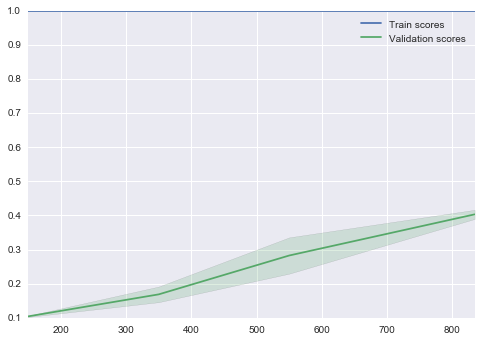

In [25]:
from sklearn.learning_curve import learning_curve
from visualization_helper import plot_score_curves

train_sizes, train_scores, valid_scores = learning_curve(
    SVC(), X_train, y_train, train_sizes=[150, 350, 550, 834], cv=3)

plot_score_curves(train_scores, valid_scores, train_sizes)

This is a clear sign of high variance (overfitting): the training score is very high but the validation one is very low. The added information in this case is that adding more data helps.

An high bias case is typically represented by a training score that starts to decline while the validation score increases up to a point where the score stabilizes. In these cases you should try to reduce the regularization of your model or move to a more powerfull one.

Although the proper way of choosing hyper-parameters is by using *Grid Search* or *Random Search*, you might want to see how the choice of parameter influences the final result. You can do that using the *validation_curve* method.

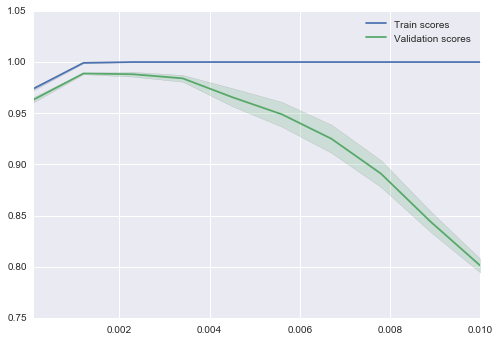

In [26]:
from sklearn.learning_curve import validation_curve

values = np.linspace(0.0001, 0.01, 10)
train_scores, valid_scores = validation_curve(SVC(), X_train, y_train, 'gamma', values)

plot_score_curves(train_scores, valid_scores, values)

## Model Persistence ##

It is possible to use ```pickle``` to save scikit objects:

```python 
pickle.dump(clf, f_write)
clf2 = pickle.load(f_read)
```

Nonetheless, pickle might not be efficient saving large numpy arrays. Scikit-learn recommends the usage of ```joblib``` to do that:

In [27]:
from sklearn.externals import joblib
joblib.dump(pipeline, 'pipeline.pkl')
pipeline2 = joblib.load('pipeline.pkl')

print 'Checking if loaded pipeline gives same results: {0:.2f} = {1:.2f}'.format(pipeline.score(X, y), pipeline2.score(X, y))

Checking if loaded pipeline gives same results: 0.98 = 0.98


As we can see, ```joblib```'s interface is the same as ```pickle```'s. There is no guarantees that a model saved in one version of scikit-learn will be compatible with a newer one.

**Warning:** Use this only for development in a trusted and secure environment. An untrusted source may change the data without your knowledge. This is valid for pickle also.